In [3]:
import pandas as pd

data = pd.read_csv('processed_headlines_locations.csv', index_col=0)
data[['headline', 'cities', 'latitude', 'longitude', 'countrycode']].head()

,headline,cities,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US


In [4]:
print('Missing Values:')
data.isna().sum()

Missing Values:


headline         0
cities           0
accented_city    0
latitude         0
longitude        0
countrycode      0
pop              0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 646
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   headline       603 non-null    object 
 1   cities         603 non-null    object 
 2   accented_city  603 non-null    object 
 3   latitude       603 non-null    float64
 4   longitude      603 non-null    float64
 5   countrycode    603 non-null    object 
 6   pop            603 non-null    float64
dtypes: float64(3), object(4)
memory usage: 37.7+ KB


In [6]:
from sklearn.cluster import DBSCAN

# Default sklearn parameters
clusterer = DBSCAN()
clusterer

DBSCAN()

In [7]:
def cluster_location(clusterer, data, lat_string="latitude", lon_string="longitude"):
    """
    Fit a clustering algorithm on location data.
    """
    features = data[[lat_string, lon_string]].copy()
    clusterer.fit(features)
    # Assign the cluster labels
    data["cluster"] = clusterer.labels_
    return data

In [8]:
data = cluster_location(clusterer, data)
data['cluster'].value_counts()

-1    476
 4     26
 1     21
 0     19
 6     14
 3     12
 7     10
 5      8
 9      6
 2      6
 8      5
Name: cluster, dtype: int64

In [9]:
clusterer.eps = 9
data = cluster_location(clusterer, data)
data['cluster'].value_counts()

 0     369
 2      59
 3      57
-1      32
 1      21
 5      16
 8       9
 4       9
 6       8
 11      7
 9       6
 7       6
 10      4
Name: cluster, dtype: int64

In [10]:
clusterer.min_samples = 3
data = cluster_location(clusterer, data)
data['cluster'].value_counts()

 0     371
 4      62
 2      59
 1      21
-1      16
 8      16
 11      9
 10      9
 5       9
 9       8
 12      6
 7       6
 3       5
 13      3
 6       3
Name: cluster, dtype: int64

In [11]:
best_euclidean_clusterer = DBSCAN(
    eps=9, min_samples=3, metric="euclidean",
)
data = cluster_location(best_euclidean_clusterer, data)

In [12]:
import numpy as np

def great_circle_distance(coord1, coord2, radius=3956):
    """
    Calculates the great circle distance between two coordinates or arrays of coordinates.
    """
    if np.array_equal(coord1, coord2):
        return 0.0

    # Convert lat/lon to radians
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    # Find the difference between the coordinates
    delta_x, delta_y = coord2 - coord1
    
    # Apply Haversin formula
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )

    # Convert to distance in miles
    return 2 * radius * np.arcsin(haversin ** 0.5)

In [13]:
data.head()

,headline,cities,accented_city,latitude,longitude,countrycode,pop,cluster
0,Zika Outbreak Hits Miami,Miami,Miami,25.77427,-80.19366,US,441003.0,0
1,Could Zika Reach New York City?,New York City,New York City,40.71427,-74.00597,US,8175133.0,0
2,First Case of Zika in Miami Beach,Miami Beach,Miami Beach,25.79065,-80.13005,US,92312.0,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Recife,-8.05389,-34.88111,BR,1478098.0,1
4,Dallas man comes down with case of Zika,Dallas,Dallas,32.78306,-96.80667,US,1300092.0,0


In [14]:
coord1 = np.array(
    [
        [data["latitude"].iloc[0], data["latitude"].iloc[1]],
        [data["longitude"].iloc[0], data["longitude"].iloc[1]],
    ]
)

coord2 = np.array(
    [
        [data["latitude"].iloc[2], data["latitude"].iloc[0]],
        [data["longitude"].iloc[2], data["longitude"].iloc[0]],
    ]
)

# Calculate distance between points
great_circle_distance(coord1, coord2)

array([   1.14462609, 1031.53567987])

In [16]:
great_circle_clusterer = DBSCAN(
    eps=250, min_samples=4, metric=great_circle_distance,
)

# Cluster using great circle distance
data = cluster_location(
     great_circle_clusterer, data, lon_string="longitude", lat_string="latitude"
)

data["cluster"].value_counts()

 0     236
-1     132
 5      59
 2      49
 4      16
 10     11
 6      11
 8      10
 9       9
 11      8
 16      8
 3       8
 7       7
 1       6
 14      5
 12      4
 20      4
 18      4
 13      4
 15      4
 17      4
 19      4
Name: cluster, dtype: int64

In [17]:
manhattan_clusterer = DBSCAN(
    eps=9, min_samples=3, metric="manhattan",
)
data = cluster_location(manhattan_clusterer, data)

In [18]:
from sklearn.cluster import KMeans

kmeans_clusterer = KMeans()
kmeans_clusterer

KMeans()

In [19]:
inertia_values = []

for k in range(1, 11):
    inertia_values.append(KMeans(n_clusters=k).fit(data[['latitude', 'longitude']]).inertia_)

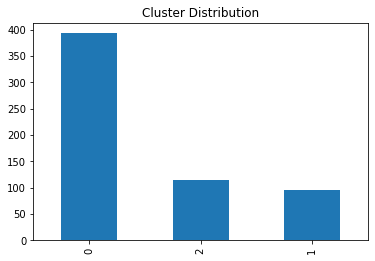

In [22]:
_ = data['cluster'].value_counts().plot.bar(title='Cluster Distribution')

In [23]:
data.groupby('countrycode')['cluster'].value_counts()['US']

cluster
0    303
Name: cluster, dtype: int64

In [24]:
data.to_csv('processed_headlines_clustered.csv')

In [26]:
data[['headline', 'cities', 'latitude', 'longitude', 'countrycode', 'cluster']].head(10)

,headline,cities,latitude,longitude,countrycode,cluster
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US,0
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US,0
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR,2
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US,0
5,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO,0
6,Zika Concerns are Spreading in Houston,Houston,29.76328,-95.36327,US,0
7,Geneve Scientists Battle to Find Cure,Geneve,46.20222,6.14569,CH,2
8,The CDC in Atlanta is Growing Worried,Atlanta,33.74900,-84.38798,US,0
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,-23.54750,-46.63611,BR,0


In [27]:
data[['headline', 'cities', 'latitude', 'longitude', 'countrycode', 'cluster']].to_csv('clustered_data.csv')